<p style="font-family:Muro;font-weight:bold;font-size:55px;margin:5px 0px 50px 0px;color:#A04720">Social Graphs 2021</p>
<p style="font-family:Verdana;font-weight:light;font-size:35px;margin:5px 0px 10px 0px;color:#ffffff">Assignment two</p>


# Part 0

To create our network, we downloaded the Zelda Wiki pages for all characters in BotW (during Week 4) and linked them via the hyperlinks connecting pages to each other. To achieve this goal we have used regular expressions!

* Explain the strategy you have used to extract the hyperlinks from the Wiki-pages, assuming that you have already collected the pages with the Zelda API.
    * In order to extract the hyperlinks from the Wiki-pages, the <code>bs4</code> also called <code>BeautifulSoup</code>. The characterlist was looped over, and using the <code>request</code> library, numerous requests were sent to the wikipage, locating the main containers and identifiying all the links using the <code>.findAll('a')</code> function in BS4. Thereafter, only characters that was in the characterlist were kept, and duplicates removed.

* Show the regular expression(s) you have built and explain in details how it works.
    * TbD


In [86]:
#Libs

import pandas as pd
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import ast, powerlaw
import seaborn as sns
from fa2 import ForceAtlas2


import warnings
warnings.filterwarnings("ignore")

## Data preprocessing

In [87]:
#Loading in the already generated dataset
df = pd.read_csv("bowFull.csv")
#Removing an undesired column
df.drop("Unnamed: 0", inplace=True, axis=1)
#Checking the datatypes
df.dtypes


Name      object
Role      object
Race      object
Gender    object
Edges     object
dtype: object

Upon inspecting the datatypes, it can be noted that the edges column has the dtype "object", when in reality it is a list:

In [88]:
df['Edges'][:3]

0                ['Link', 'Nazbi', 'Savelle', 'Yammo']
1                                           ['Baumar']
2    ['Ena', 'Hylia', 'Malanya', 'Konba', 'Chork', ...
Name: Edges, dtype: object

To be able to process this data correctly, the <code>ast.literal_eval()</code> function is casted on the PD series to turn the datatype into a list

In [89]:
df.Edges = df.Edges.map(lambda a: ast.literal_eval(a) if pd.notnull(a) else a)

Double-checking that the column has been transformed into a proper list, by accessing the elements through slicing

In [90]:
#Should return "Nazbi"
df['Edges'][0][1]

'Nazbi'

However, pure lists doesn't work well with <code>networkx</code>, which means that each element in the 'Edges' columns needs to be transformed into each own row for the specific characters. This can be done using <code>df.explode()</code>

In [91]:
df = df.explode("Edges")

In [92]:
#Inspecting the first four element to ensure column has been correctly transformed
df.head(4)

,Name,Role,Race,Gender,Edges
0,Baddek,Ally,Hylian,Male,Link
0,Baddek,Ally,Hylian,Male,Nazbi
0,Baddek,Ally,Hylian,Male,Savelle
0,Baddek,Ally,Hylian,Male,Yammo


## Building the network

The <code>.from_pandas_edgelist()</code> function takes in a dataframe, a source (nodes) and a target (edges). Adding the additional argument, <code>create_using=nx.DiGraph()</code> will ensure the network is constructed with a directional graph, so bot inwards- and outwards degrees can be counted.

In [133]:
G = nx.from_pandas_edgelist(df, 'Name', 'Edges', create_using=nx.DiGraph())

In [134]:
#Noting that there is a "nan" node that must be removed since these don't lead to a page
list(set(list(G.nodes())))[0]

nan

In [135]:
G.remove_node(np.nan)

### Extracting the Giant Connected Component (GCC)

The code below extracts the GCC from the network, i.e. the "central hub" where the most nodes are connected, effectively removing characters that are not meaningful to the end case. This can be a character who is only connected to their horse, which wouldn't provide much information to the overall network.

In [136]:
GCC = G.subgraph(sorted(nx.weakly_connected_components(G), key=len, reverse=True)[0])

print(f"Nodes that were removed: {len(G.nodes()) - len(GCC.nodes)}")


Nodes that were removed: 116


## Exercise **1a**: Stats 

    * What is the number of nodes in the network?
    * What is the number of links?
    * Who is the top connected character in BotW? (Report results for the in-degrees and out-degrees). Comment on your findings. Is this what you would have expected?

In [139]:
print(f"Nodes in the network: {len(GCC.nodes())}")
print(f"Number of links in the network: {len(GCC.edges())}")
topConnectedIn = sorted(GCC.in_degree, key=lambda x: x[1], reverse=True)[0]
print(f"The top connected character based on in-degrees is: {topConnectedIn[0]}, who has {topConnectedIn[1]} inwards connections.")
topConnectedOut = sorted(GCC.out_degree, key=lambda x: x[1], reverse=True)[0]
print(f"The top connected character based on out-degrees is: {topConnectedOut[0]}, who has {topConnectedOut[1]} outwards connections.")

Nodes in the network: 540
Number of links in the network: 2074
The top connected character based on in-degrees is: Link, who has 404 inwards connections.
The top connected character based on out-degrees is: Lizalfos, who has 28 outwards connections.


    Who are the top 5 most connected allies (again in terms of in/out-degree)?



In [140]:
#Creating a function that takes in a dataframe that is modified to only contain the relevant role, and the GCC
def findTop(inputDF, inputNetwork):

    inDegree = list(sorted(inputNetwork.in_degree, key=lambda x: x[1], reverse=True))
    outDegree = list(sorted(inputNetwork.out_degree, key=lambda x: x[1], reverse=True))

    #Sub function for calculating the top five characters within the given role
    def topFive(inputList):
        counter = 0
        placeHolderList = []
        for value in inputList:
            if value[0] in list(inputDF['Name']):
                placeHolderList.append(value)
                counter += 1
            if counter == 5:
                return placeHolderList
            
    inDegreeList = topFive(inDegree)
    outDegreeList = topFive(outDegree)

    #Returning both in- and out degree for the relevant characters
    return inDegreeList, outDegreeList

#Function for printing out the relevant information
def printTop(inputList, types, inOut, amount=5):

    print(f"\n-----Top {amount} {types} with {inOut} degree------")
    
    for i, character in enumerate(inputList):
        print(f"#{i}: {character}")


With the relevant functions created, creating a seperate DataFrame with only characters with the role *ally* will be selected, and printed.

In [141]:
onlyAllies = df.loc[df['Role'] == "Ally"]

topIn, topOut = findTop(onlyAllies, GCC)


printTop(topIn, "allies", "inwards")
printTop(topOut, "allies", "outwards")


-----Top 5 allies with inwards degree------
#0: ('Link', 404)
#1: ('Hylia', 67)
#2: ('Princess Zelda', 33)
#3: ('Mipha', 25)
#4: ('Riju', 23)

-----Top 5 allies with outwards degree------
#0: ('Link', 16)
#1: ('Impa', 15)
#2: ('Traysi', 14)
#3: ('Princess Zelda', 12)
#4: ('Daruk', 11)


Again, the same for enemies and bosses.

In [142]:
onlyEnemies = df.loc[(df['Role'] == "Enemy") | (df['Role'] =="Boss")]

topIn, topOut = findTop(onlyEnemies, GCC)

printTop(topIn, "enemies", "inwards")
printTop(topOut, "enemies", "outwards")



-----Top 5 enemies with inwards degree------
#0: ('Calamity Ganon', 105)
#1: ('Lizalfos', 27)
#2: ('Bokoblin', 26)
#3: ('Hinox', 23)
#4: ('Master Kohga', 20)

-----Top 5 enemies with outwards degree------
#0: ('Lizalfos', 28)
#1: ('Hinox', 21)
#2: ('Stone Talus', 20)
#3: ('Moblin', 18)
#4: ('Windblight Ganon', 17)


    Plot the in- and out-degree distributions.


Text(0.5, 0, 'Amount of outward links')

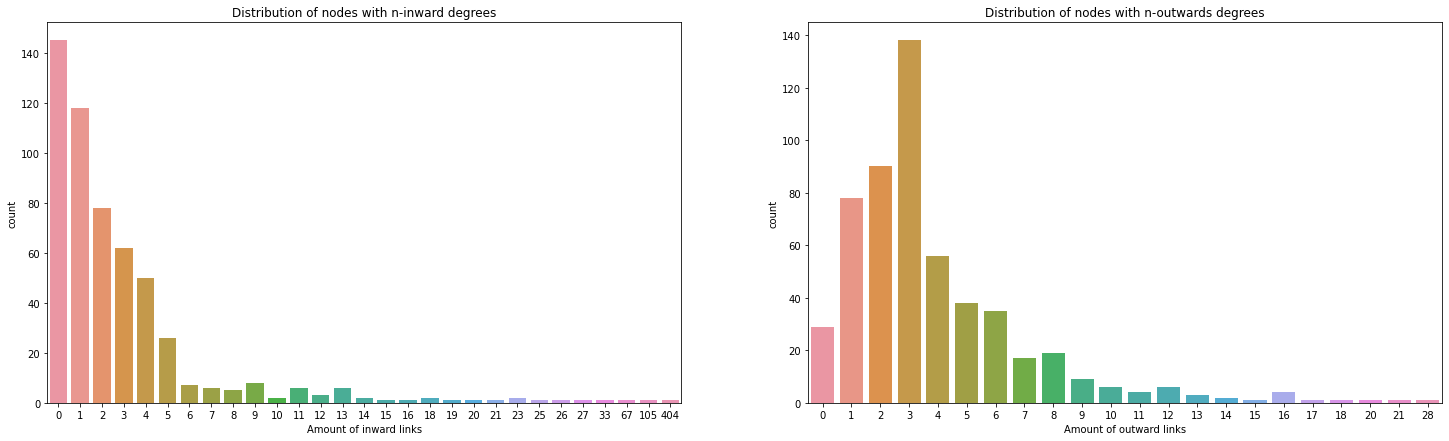

In [143]:
#Dividing into two subplots to more easily see the differences
fig, axs = plt.subplots(1, 2)
fig.set_size_inches(25,7)


sns.countplot(list(dict(GCC.in_degree).values()), ax=axs[0])
axs[0].set_title("Distribution of nodes with n-inward degrees")
axs[0].set_xlabel("Amount of inward links")

sns.countplot(list(dict(GCC.out_degree).values()), ax=axs[1])
axs[1].set_title("Distribution of nodes with n-outwards degrees")
axs[1].set_xlabel("Amount of outward links")



    What do you observe?

* Inward degree distribution
    * The inward degree distribution follows a power law like pattern, where there is a significant number of characters with none-to-small amount of inward links, and extremely few of the larger occurences. The reason for the unbelivable high amount of characters with zero inwards degrees, is that many characters in the game are rather insignificant for the main story and therefore not mentioned in othere characters' pages. Another factor can also be those characters that are so insignificant that they do not have a designated wiki page with information, e.g. <a href="https://zelda.fandom.com/wiki/Monya_Toma#Breath_of_the_Wild">Monya Toma</a>
* Outward degree distribution
    * The outward degree distribution is a bit different, having zero characters with no outward connections, looking more similar to a Poisson distribution. The reason for this is not unexpected, as the characters who would not point to another page would be removed when creating the GCC. This in turn results in many characters having one link, as there wouldn't be the need for a wikipedia page if the character would be so insignificant that they didn't connect to any other characters. The distribution is also less extreme, with the amount of outward links being incremental.


**Can you explain why the in-degree distribution is different from the out-degree distribution?**

To summarize, the difference can be explained by a combination of factors. The generation of the GCC, eliminated all "isolated nodes" and only kept the ones that had at least one outward connections. Additionally, as is stated by the power law, a network usually consists of a few central nodes, or "hubs", that has few outward links but that most other characters are connected to. Especially in video games where you have protagonists and antagonists, these characters will be extremely central and interacts with most characters at a given point. While these interactions can be central for the smaller characters, in explaining their background, they are insignificant for main characters stories, and the direction will then be one-sided.


    Find the exponent of the degree distribution (by using the powerlaw package) for the in- and out-degree distribution.


In [144]:
def powerlaw_exponent(degreeList):
    gamma = powerlaw.Fit(degreeList).alpha
    return gamma

In [145]:
inDegree = powerlaw_exponent(list((dict(GCC.in_degree).values())))
outDegree = powerlaw_exponent(list((dict(GCC.out_degree).values())))

Calculating best minimal value for power law fit
Calculating best minimal value for power law fit


Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values


In [146]:
print(f"""
Exponent for the in-degree: {inDegree} 
Exponent for the out-degree: {outDegree} 
""")


Exponent for the in-degree: 2.729779372119334 
Exponent for the out-degree: 4.081957099901511 



    What does it say about our network?

The powerlaw exponent, $\gamma$, is found to be $\gamma \approx 2.7$ for the in-degree and $\gamma \approx 4$ for the out-degree. According to Barbasi (Barabasi, 4.7), this would put the in-degree network in the scale free regime, and the out-degree in the random network regime. This was expected, as multiple hubs were noticed in the in-degree network, opposed to none in the out-degree network, as is common in these networks:
> In a random network most nodes have comparable degrees and hence hubs are forbidden. Hubs are not only tolerated, but are expected in scale-free networks (Image 4.6). Furthermore, the more nodes a scalefree network has, the larger are its hubs. Indeed, the size of the hubs grows polynomially with network size, hence they can grow quite large in scalefree networks. In contrast in a random network the size of the largest node grows logarithmically or slower with N, implying that hubs will be tiny even in a very large random network. (Barbasi, 4.3)

    Compare the degree distribution of the undirected graph to a random network with the same number of nodes and probability of connection p.

When generating an Erdos Renyi graph, the parameters needed are $n$, for the amount of nodes the network should have, and $p$, the probability that a node is connected. These can be found by using the already generated GCC.


In [147]:

N = len(GCC.nodes())
k = sum(dict(GCC.degree).values()) / len(GCC.nodes())
p = k/(N-1)

E = nx.erdos_renyi_graph(N, p)



Now that a random generated network with the same specifications have been created, the degree distributions can be plotted to measure them against each other.

Text(0.5, 0, 'Degree count')

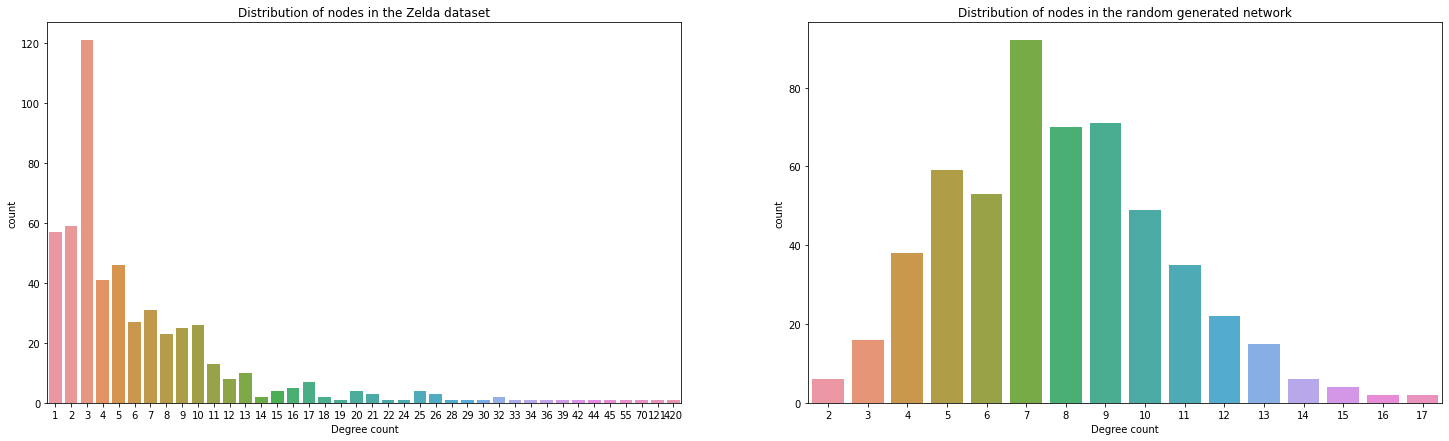

In [148]:
fig, axs = plt.subplots(1, 2)
fig.set_size_inches(25,7)


sns.countplot(list(dict(GCC.degree).values()), ax=axs[0])
axs[0].set_title("Distribution of nodes in the Zelda dataset")
axs[0].set_xlabel("Degree count")

sns.countplot(list(dict(E.degree).values()), ax=axs[1])
axs[1].set_title("Distribution of nodes in the random generated network")
axs[1].set_xlabel("Degree count")

    Comment your results.

Comparing the zelda dataset with the random generated ER, the differences are apparent. Firstly, the Zelda dataset follows a Powerlaw distribution and will therefore be right-tailed, where most characters have few edges, as well as some minor hubs at the very end that have a high degree count, since they are central to the video game. On the other hand, the random generated ER network will follow a normal distribution, where most of the nodes will be centered around the mean, with some outliers on both sides. 

# Exercise 1B

    * Create a nice visualization of the total (undirected) network:

As is mentioned in the task description, the network will be transformed into an undirected one to make the graph more visually appealing and easier to comprehend.

In [149]:

V = GCC.to_undirected()

    Color nodes according to the role;

In [150]:
def generateColorList(graphObject):
    '''
    Generates the colorList to be used in the getNodeColors function
    '''
    dfNotExploded = pd.read_csv("bowFull.csv")
    nodeList = list(graphObject.nodes())

    colorList = [dfNotExploded.loc[dfNotExploded['Name'] == node]['Role'].values[0] for node in nodeList]

    return colorList

def getNodeColors(graph):
    '''
    Returns node color map according to the Role
    '''
    color_map = []
    for role in graph:
        if role == "Ally":
            color_map.append("#50c878")
        elif role == "Enemy":
            color_map.append("#ff9100")
        else:
            color_map.append("#900000")
    return color_map

    Scale node-size according to degree;


In [152]:

def getNodeSize(graph):
    '''
    Returns the node size based on the degree count
    '''
    degrees = dict(graph.degree)
    return [v*5 for v in degrees.values()]


In [ ]:
def get_edge_color(graph, n1, n2):
    '''
    Return edge color between two nodes
    '''
    univ1, univ2 = graph.nodes[n1]['universe'], graph.nodes[n2]['universe']
    if univ1 == univ2 == 'marvel':
        return 'blue'
    if univ1 == univ2 == 'dc':
        return 'yellow'
    return 'green'


def get_edge_color_map(graph):
    '''
    Returns edge color map taking universe into account
    '''
    return [get_edge_color(graph, n1, n2) for n1, n2 in graph.edges]

100%|██████████| 500/500 [00:04<00:00, 102.50it/s]


BarnesHut Approximation  took  0.64  seconds
Repulsion forces  took  4.01  seconds
Gravitational forces  took  0.03  seconds
Attraction forces  took  0.02  seconds
AdjustSpeedAndApplyForces step  took  0.10  seconds


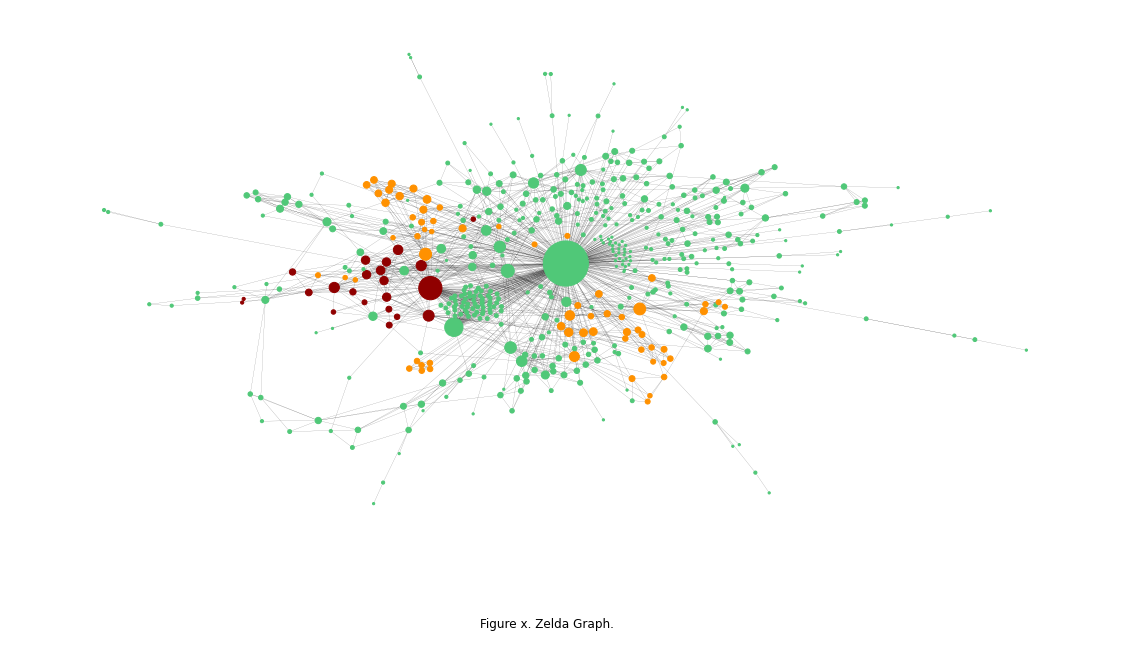

In [156]:
fig, ax = plt.subplots()
fig.set_size_inches(20,10)

positions = ForceAtlas2().forceatlas2_networkx_layout(V, pos=None, iterations=500)
nx.draw_networkx_nodes(
    V,
    positions,
    node_size=getNodeSize(V),
    node_color=getNodeColors(generateColorList(V)))
nx.draw_networkx_edges(
    V,
    positions,
    width=0.1
    # edge_color=get_edge_color_map(zeldaUndirected)
    )

# nx.draw_networkx_labels(G0[:5], positions)


plt.axis('off')
caption = '''
Figure x. Zelda Graph.
'''
plt.figtext(0.5, 0, caption, wrap=True, horizontalalignment='center', fontsize=12)
ax.set_facecolor("#FFFFFF")
plt.show()


[0.2,
 20.400000000000002,
 0.1,
 0.05,
 0.05,
 0.05,
 0.15,
 0.45,
 0.4,
 3.35,
 0.2,
 0.1,
 0.4,
 0.4,
 0.35000000000000003,
 0.3,
 0.25,
 0.15,
 0.1,
 0.15,
 0.1,
 0.1,
 0.75,
 0.15,
 1.7,
 0.4,
 0.15,
 0.4,
 0.15,
 0.15,
 0.3,
 0.5,
 0.1,
 0.15,
 0.25,
 1.4000000000000001,
 0.7000000000000001,
 0.5,
 0.3,
 0.65,
 0.15,
 0.05,
 0.1,
 0.85,
 0.45,
 5.4,
 0.7000000000000001,
 0.75,
 0.5,
 0.7000000000000001,
 0.55,
 1.3,
 0.05,
 0.15,
 0.25,
 0.25,
 0.15,
 0.2,
 0.7000000000000001,
 1.05,
 0.15,
 1.35,
 0.9500000000000001,
 0.3,
 0.05,
 0.35000000000000003,
 0.4,
 0.3,
 0.2,
 0.2,
 0.15,
 0.1,
 0.3,
 0.15,
 0.3,
 0.4,
 0.25,
 0.3,
 0.4,
 0.5,
 0.05,
 0.4,
 0.3,
 1.05,
 0.15,
 0.1,
 0.1,
 0.2,
 0.3,
 0.3,
 0.25,
 0.05,
 0.1,
 0.65,
 1.1,
 0.2,
 0.7000000000000001,
 0.3,
 0.3,
 0.15,
 0.15,
 0.15,
 0.15,
 0.9,
 0.3,
 0.3,
 0.05,
 0.15,
 1.2,
 0.4,
 0.5,
 0.7000000000000001,
 0.05,
 0.05,
 0.05,
 0.3,
 0.2,
 0.3,
 0.25,
 0.3,
 0.15,
 0.15,
 0.05,
 0.35000000000000003,
 0.1,
 0.3,
 0.15,
